<b>Provided Data and Definitions:</b>  
The data represents a set of clicks registered by users searching and clicking on ads on the internet.    
- click_status: shows if a click is valid or invalid  
- Timestamp: time of the click  
- Query Term: the keywords/query the user used in her/his search  
- IP Address: unique address of the machine the user used in her search  
- User Agent: A string representing OS, Browser data and Device type the user used  
- CPC (Cost Per Click): in dollar value  
- Conversion: action taken on advertiser landing page (purchase, sign up, site visit).    

<b>Assignment:</b>  
Assume you were to join the team and your task is to utilize the data provided to inform stakeholders on current status, trends and potential optimization strategies.Some suggestions on how you can approach the exercise:  
- Understand the underlying data and definitions.  
- Describe specific metrics you would use to draw business insights and build strategy  
- Any insights on how to drive more efficient Cost per Conversions?  

<b>Deliverable:</b>  
While no specific format is required. Keep in mind that we will be assessing you on the content, clarity and conciseness of your presentation. Please be sure to provide your code (if any) used to obtain the results.  

Please submit this assignment by Friday, August 13th at 12pm.


# 1 Data prepartion

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from datetime import datetime
import time
from geolite2 import geolite2


In [2]:
raw_data = pd.read_excel('Rawdata.xlsx')

## 1.1 sanity check 

In [3]:
raw_data.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions
0,1,42033.458333,"[""michael kors"",""michael michael kors""]",2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0
1,1,42033.458333,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0
2,1,42033.458333,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0
3,1,42033.458333,"[""credit report"",""credit karma"",""free online c...",219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0
4,1,42033.458333,"[""Byethost""]",13.54.12.142,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,0.168783,0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   click_status     10103 non-null  int64  
 1   AMP_timestamp    10103 non-null  float64
 2   Query Term       10103 non-null  object 
 3   IP Address       10103 non-null  object 
 4   User Agent       10103 non-null  object 
 5   Cost Per Click   10103 non-null  float64
 6   Conversions      10103 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 552.6+ KB


In [5]:
raw_data.describe(include= 'object')

,Query Term,IP Address,User Agent
count,10103,10103,10103
unique,2587,8266,1913
top,"[""car title loans"",""loan quotes"",""car financing""]",78.55.179.233,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
freq,317,13,439


## 1.2 remove duplicates

In [6]:
sum(raw_data.duplicated())

420

As we can see, there are 420 duplicates in the raw data. Since each row represents a single click, it doesn't make sense that users can do single click for muiltiple times at exact same time. I removed these dups (keep the first record) for further analysis.

In [7]:
data = raw_data.drop_duplicates(keep='first')

In [8]:
raw_data.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions
0,1,42033.458333,"[""michael kors"",""michael michael kors""]",2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0
1,1,42033.458333,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0
2,1,42033.458333,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0
3,1,42033.458333,"[""credit report"",""credit karma"",""free online c...",219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0
4,1,42033.458333,"[""Byethost""]",13.54.12.142,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,0.168783,0


## 1.3 keep validated clicks only
Given the fact that (Click Status = 1 means valid Click Status > 1 means invalidated), I first calculated the unvalidated percentage

In [9]:
print(
    'The unvalidated ratio is {:.0f}%'.format(
        raw_data[raw_data.click_status > 1].shape[0] / raw_data.shape[0] *100
    )
)

The unvalidated ratio is 14%


As we can see, the unvalidated ratio only accounts for a small proportion.It is safe to remove those unvalidated data.

In [10]:
#only validated data
data = data[data['click_status'] == 1]
data.shape

(8363, 7)

In [11]:
# convert timestamp to datetime
def get_date(ts):
    """
    address date format issue from excel file
    """
    delta = pd.Timedelta(str(ts) + 'days')
    time = pd.to_datetime('1899-12-30') + delta
    return time

data['AMP_timestamp'] = data['AMP_timestamp'].apply(lambda x: get_date(x))

data.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions
0,1,2015-01-29 10:59:59.999971200,"[""michael kors"",""michael michael kors""]",2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0
1,1,2015-01-29 10:59:59.999971200,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0
3,1,2015-01-29 10:59:59.999971200,"[""credit report"",""credit karma"",""free online c...",219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0
4,1,2015-01-29 10:59:59.999971200,"[""Byethost""]",13.54.12.142,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,0.168783,0
5,1,2015-01-29 10:59:59.999971200,"[""online education games for kids"",""games for ...",174.176.23.147,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:35.0) G...,0.256422,0


## 1.4 parse  IP address

In [12]:
geo = geolite2.reader()

def get_loc(ip):
    """
    get country location from ip adress
    
    """
    try:
        x = geo.get(ip)
    except ValueError:   #Faulty IP value
        return np.nan
    try:
        return x['country']['names']['en'] if x is not None else np.nan
    except KeyError:   #Faulty Key value
        return np.nan

s_time = time.time()

data['country'] = data.loc[:,'IP Address'].apply(get_loc)

data.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions,country
0,1,2015-01-29 10:59:59.999971200,"[""michael kors"",""michael michael kors""]",2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0,Italy
1,1,2015-01-29 10:59:59.999971200,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0,NaN
3,1,2015-01-29 10:59:59.999971200,"[""credit report"",""credit karma"",""free online c...",219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0,Japan
4,1,2015-01-29 10:59:59.999971200,"[""Byethost""]",13.54.12.142,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,0.168783,0,Australia
5,1,2015-01-29 10:59:59.999971200,"[""online education games for kids"",""games for ...",174.176.23.147,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:35.0) G...,0.256422,0,United States


## 1.5 parse UA

In [13]:
#! pip install ua-parser
from ua_parser import user_agent_parser
import pprint
pp = pprint.PrettyPrinter(indent=4)

def parse_ua(ua):
    
    """
    get os, browser and device type
    
    """
    # get OS
    try:
        os = user_agent_parser.ParseOS(ua)['family']
    except ValueError:
        os = np.nan
    
    # get browser
    try:
        browser = user_agent_parser.ParseUserAgent(ua)['family']
    except ValueError:
        browser = np.nan
        
    # get device
    try:
        device = user_agent_parser.ParseDevice(ua)['family']
    except ValueError:
        device = np.nan
        
    return os, browser, device
    

data['os'], data['browser'], data['device'] = zip(*data['User Agent'].apply(parse_ua))

In [14]:
data.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions,country,os,browser,device
0,1,2015-01-29 10:59:59.999971200,"[""michael kors"",""michael michael kors""]",2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0,Italy,iOS,Mobile Safari,iPad
1,1,2015-01-29 10:59:59.999971200,"[""meet girls"",""dating girls""]",0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0,NaN,Windows,Firefox,Other
3,1,2015-01-29 10:59:59.999971200,"[""credit report"",""credit karma"",""free online c...",219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0,Japan,Windows,Chrome,Other
4,1,2015-01-29 10:59:59.999971200,"[""Byethost""]",13.54.12.142,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,0.168783,0,Australia,Windows,Zune,Other
5,1,2015-01-29 10:59:59.999971200,"[""online education games for kids"",""games for ...",174.176.23.147,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:35.0) G...,0.256422,0,United States,Windows,Firefox,Other


# 2. Explortory Analysis

## 2.1 Data Overview

In [15]:
print("After cleasing data, we have {} data points".format(data.shape[0]))

After cleasing data, we have 8363 data points


## 2.2 Search by Country

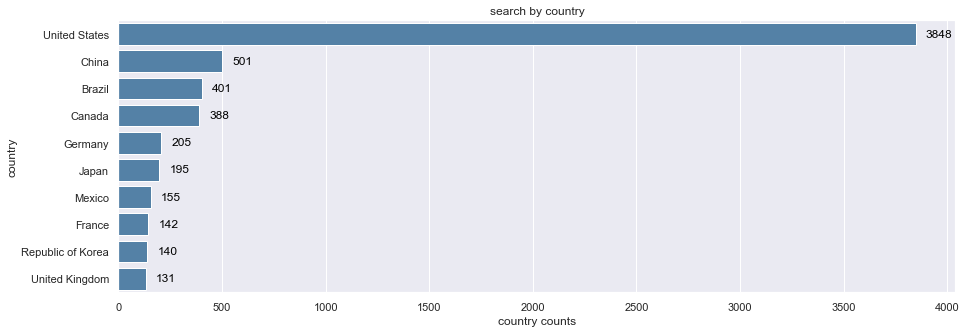

In [16]:
 def plot_country(data):
    """
    visualize the country distribution 
    
    """
    
    country_count = data.groupby(['country'])['AMP_timestamp'].count().reset_index().rename(
        columns = {
        'AMP_timestamp': 'search_cnt'
        }   
    ).sort_values('search_cnt', ascending = False).head(10) #top 10 countries
    
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 5))
    

    sns.barplot(
        'search_cnt',
        country_count['country'].astype('str'),
        data = country_count,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(i.get_width() + 50,
                i.get_y() + 0.5,
                '{0:.0f}'.format(i.get_width()),
                fontsize = 12,
                color='black'
               )
    plt.xlabel('country counts')
    plt.ylabel('country')
    plt.title('search by country')
    
plot_country(data)

As we can see from the barplot above, the majority of searches are from the US.The 2nd, 3rd and 4th account for similary precentage

## 2.3 Search by device 

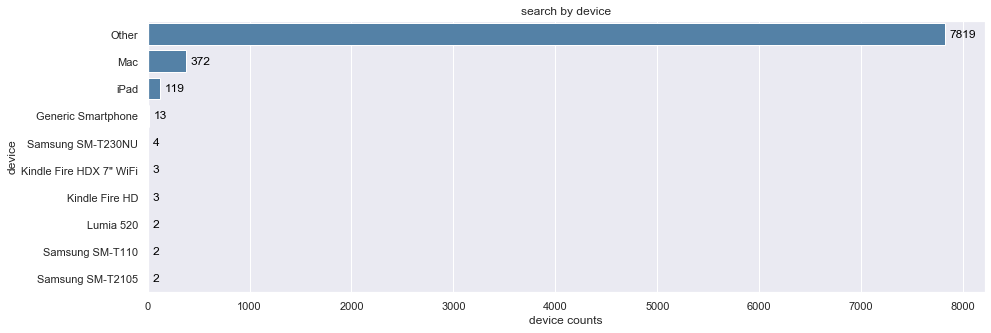

In [17]:
 def plot_device(data):
    """
    visualize the device distribution 
    
    """
    
    device_count = data.groupby(['device'])['AMP_timestamp'].count().reset_index().rename(
        columns = {
        'AMP_timestamp': 'search_cnt'
        }   
    ).sort_values('search_cnt', ascending = False).head(10) #top 10 countries
    
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 5))
    

    sns.barplot(
        'search_cnt',
        device_count['device'].astype('str'),
        data = device_count,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(i.get_width() + 50,
                i.get_y() + 0.5,
                '{0:.0f}'.format(i.get_width()),
                fontsize = 12,
                color='black'
               )
    plt.xlabel('device counts')
    plt.ylabel('device')
    plt.title('search by device')
    
plot_device(data)

We can see 372 searches are from Mac and 119 are from iPad. Although for most searches, we are not able to fetch the device name, we still can infer from the OS system, which is shown below.

## 2.4 search by OS

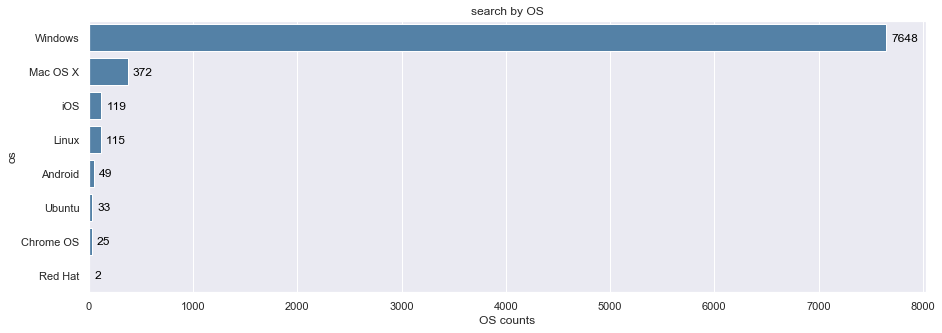

In [18]:
 def plot_os(data):
    """
    visualize the device distribution 
    
    """
    
    os_count = data.groupby(['os'])['AMP_timestamp'].count().reset_index().rename(
        columns = {
        'AMP_timestamp': 'os_cnt'
        }   
    ).sort_values('os_cnt', ascending = False).head(10) #top 10 countries
    
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 5))
    

    sns.barplot(
        'os_cnt',
        os_count['os'].astype('str'),
        data = os_count,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(i.get_width() + 50,
                i.get_y() + 0.5,
                '{0:.0f}'.format(i.get_width()),
                fontsize = 12,
                color='black'
               )
    plt.xlabel('OS counts')
    plt.ylabel('os')
    plt.title('search by OS')
    
plot_os(data)

If we compare the breakdown of OS with the one of device, we can infer most 'other' device should be Windows PC, which makes sense - there are a bunch of devices running Windows OS and it is hard to identify each of them.

## 2.5 Top 30 keywords and conversions

First we want to see what are the most frequent keywords users are searching. For each of them, I wanted to see the how many of them led to conversion (conversions > 1).  Here I selected top 30 keywords.

In [19]:
# remove blank in 'Query Term '
data = data.rename(
    columns={
        'Query Term ':'Query Term'
    }
)

In [20]:
def remove_brackets(string):
    string = string.replace('[',"")
    string = string.replace(']',"")
    string = string.replace("\"","")
    string = string.split(',')
    return string

data['Query Term'] = data['Query Term'].apply(remove_brackets)
data['Query Term'] = data['Query Term'].astype('object')
data_explode = data.explode('Query Term')
data_explode.head()

,click_status,AMP_timestamp,Query Term,IP Address,User Agent,Cost Per Click,Conversions,country,os,browser,device
0,1,2015-01-29 10:59:59.999971200,michael kors,2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0,Italy,iOS,Mobile Safari,iPad
0,1,2015-01-29 10:59:59.999971200,michael michael kors,2.118.171.21,Mozilla/5.0 (iPad; CPU OS 8_1 like Mac OS X) A...,0.279621,0,Italy,iOS,Mobile Safari,iPad
1,1,2015-01-29 10:59:59.999971200,meet girls,0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0,NaN,Windows,Firefox,Other
1,1,2015-01-29 10:59:59.999971200,dating girls,0.82.173.102,Mozilla/5.0 (Windows NT 5.1; rv:35.0) Gecko/20...,0.169642,0,NaN,Windows,Firefox,Other
3,1,2015-01-29 10:59:59.999971200,credit report,219.32.49.92,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.901687,0,Japan,Windows,Chrome,Other


In [21]:
# group by keywords

data_keywords_all = data_explode.groupby('Query Term')['AMP_timestamp'].count().reset_index().rename(
    columns = {
        'AMP_timestamp': 'word counts'
    }
)
top30_all = data_keywords_all.sort_values("word counts", ascending = False).head(30)
top30_all

,Query Term,word counts
1902,loan quotes,913
1334,car title loans,913
1714,goolg,415
2521,youtuby,406
2113,pediatric job,338
1573,facebook,330
1318,car finance calculator,294
1319,car financing,293
1366,century 21 real estate,271
1613,force download,270


In [22]:
# for top 30, how many of them bring conversions 
conv = data_explode[
    (data_explode['Query Term'].isin(top30_all['Query Term']))
    & (data_explode['Conversions']> 0)
]


top30_cov = conv.groupby('Query Term')['AMP_timestamp'].count().reset_index().rename(
    columns = {
        'AMP_timestamp': 'word counts'
    }
).sort_values('word counts',ascending = False)

top30_cov

,Query Term,word counts
4,car title loans,699
7,loan quotes,699
11,pediatric job,248
3,car financing,241
2,car finance calculator,235
8,new car payment,224
6,edu online info,127
9,online degree program,127
5,degree programs,126
0,Craigslist ORG,123


In [23]:
# keep same length/ y-axis
not_in = list(top30_all.loc[~top30_all['Query Term'].isin(top30_cov['Query Term']), 'Query Term'])
not_in = pd.DataFrame(not_in, columns=['Query Term'])
not_in['word counts'] = 0

# concate not_in with top30 that bring conversions
top30_cov = pd.concat([top30_cov, not_in])
top30_cov

,Query Term,word counts
4,car title loans,699
7,loan quotes,699
11,pediatric job,248
3,car financing,241
2,car finance calculator,235
8,new car payment,224
6,edu online info,127
9,online degree program,127
5,degree programs,126
0,Craigslist ORG,123


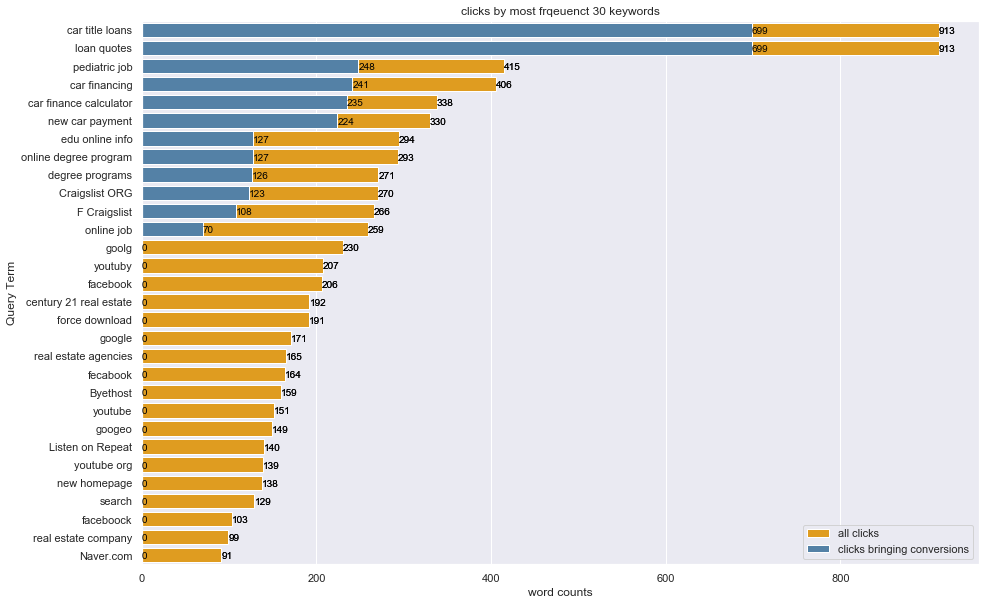

In [24]:
def plot_conversions(top30_cov, top30_all):
    

    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))
    

    plt.xlabel('valid conversion frequency')
    plt.ylabel('top20 keywords')
    plt.title('clicks by most frqeuenct 30 keywords')
    

        
    sns.barplot('word counts',
                'Query Term',
                data = top30_all,
                color = 'orange',
                label = 'all clicks '
               )
    
    for i in ax.patches:
        ax.text(i.get_width(),
                i.get_y() + 0.6,
                '{0:.0f}'.format(i.get_width()),
                fontsize = 10,
                color='black'
               )
        
        
    sns.barplot('word counts',
        'Query Term',
        data = top30_cov,
        color = 'steelblue',
        label = 'clicks bringing conversions'
       )
    
    for i in ax.patches:
        ax.text(i.get_width(),
                i.get_y() + 0.6,
                '{0:.0f}'.format(i.get_width()),
                fontsize = 10,
                color='black'
               )

    plt.legend()
                
plot_conversions(top30_cov, top30_all)

As we can see, 'car title loans' and 'loan quote' are the top 2 keywords in terms of both total clicks and clicks that leads to conversions.However, there are also a few top 30 keywords that lead to 0 conversions.

## 2.6 CPC

In [25]:
cpc = data_explode.groupby('Query Term')['Cost Per Click '].mean().reset_index().rename(
    columns = {
        'Cost Per Click ': 'avg CPC'
    }
)
top30_cpc = cpc.sort_values("avg CPC", ascending = False).head(30)

top30_cpc

,Query Term,avg CPC
1627,free filing,27.099787
1799,income taxes,9.144066
1817,intuit turbotax,8.876638
9,1800contacts,8.007334
33,800contacts,8.007334
2298,tax payments,6.151446
2366,turbotax,5.004338
1302,buy contact lenses online,4.454511
1326,car mazda,4.187297
1858,kaiser permanente physicians,3.936409


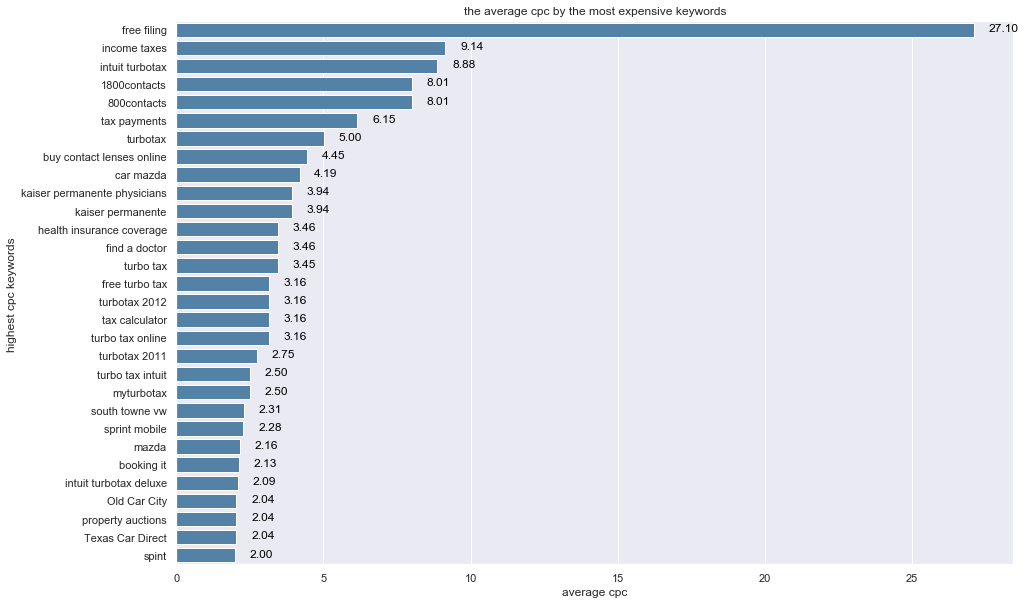

In [26]:
def plot_CPC(data):
    """
    visualize the average cpc by the most expensive keywords
    
    """

    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))
    

    sns.barplot(
        'avg CPC',
        'Query Term',
        data = data,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(i.get_width()+ 0.5,
                i.get_y() + 0.5,
                '{0:.2f}'.format(i.get_width()),
                fontsize = 12,
                color='black'
               )
    plt.xlabel('average cpc')
    plt.ylabel('highest cpc keywords ')
    plt.title('the average cpc by the most expensive keywords')
    
plot_CPC(top30_cpc)

Free filling has the highest average CPC, which is far beyond other keywords. Many of these keywords are related to law firms, which makes sense - as this topic/industry usually has higher CPC than others. However if we compare these most expensive keywords with the most frequent and conversion-effective keywords, we can see the preformance of them is not fruitful.So to lower our average CPC, we can lower our bid for these keywords or pause them directly.

# 3. Summary

#### So far we already went through all the metrics I used for our analysis:  

- location: identify our biggest market
- OS: understand what operating system we should optimize for 
- device: know what platform our users like most
- top keywords and conversions: know what keywords users are searching and how the conversion looks like
- CPC: calculate average cpc and the breakdown

#### For potential enhancement:
 - mainly focus on optimizing PC browsing exprience for Windows. For example, make layout align with 16:10 ratio(most Windows devices screen ratio) add shortcuts for Windows keyboard
 - if possible, put some efforts on mobile devices as well, like tablet and smartphone.
 - find alternatives for best keywords and topic (like "loan"), which leads to most conversions
 




#### To drive more efficient, there are three main ways:
 - focus on top keywords. We can do some drill down on them, like finding alternative keywords. For instance, we can find some keywords related to loan
 - pause non-converting keywords. From the diagram above, we can see there are a few keywords that have 0 coversion. Although they are still relatively popular, we still should drop them or lower the bids for them as they have no contribution to our business at this point
 - lower bid for high CPC keywords that has lower conversions